### TO DO
- [x] prob massing err vs sample rate for diff scale params (prob massing error as one number)
- [ ] prob massing err: importance sampling vs random + one good

## Questions?
- how to relate effect of scale param and sample rate? e.g. 10% sample equiv to halving scale parameter i.e. doubling variation of error
- how does scale parameter (variation of error) relate to coefficient magnitudes/t-stats/std errs
- nerella and bhat, failure to account for variation due to model efficiency on effect of sample rate??

In [1]:
import pandas as pd
import numpy as np
import jax.random as random
import time
from jax.lib import xla_bridge
import argparse
import os

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

In [3]:
os.chdir('..')
from scripts import large_mnl as lmnl
from scripts import compute_iter_metrics as cim

In [4]:
import statsmodels.api as sm

In [24]:
num_alts, num_choosers = 200, 750

In [25]:
choosers, alts = cim.create_data(num_alts, num_choosers)

In [26]:
coeffs = np.array([-1, 1, 1, 1, 1])

In [27]:
key = random.PRNGKey(0)

In [31]:
%%time
probs = lmnl.get_probs(choosers, alts, coeffs, key, sample_size=50, scale=1, batched=True)

CPU times: user 751 ms, sys: 36.3 ms, total: 787 ms
Wall time: 274 ms


In [32]:
probs = np.array(probs)

ValueError: x and y must have same first dimension, but have shapes (50,) and (750, 50)

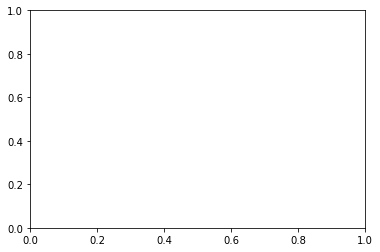

In [34]:
plt.plot(np.arange(50), np.sort(probs.sum(axis=0)))

In [9]:
probs_1 = lmnl.get_probs(choosers, alts, coeffs, key, scale=1)
utils_1 = lmnl.get_probs(choosers, alts, coeffs, key, scale=1, utils=True)

probs_2 = lmnl.get_probs(choosers, alts, coeffs, key, scale=0.5)
utils_2 = lmnl.get_probs(choosers, alts, coeffs, key, scale=0.5, utils=True)

probs_3 = lmnl.get_probs(choosers, alts, coeffs, key, scale=1.5)
utils_3 = lmnl.get_probs(choosers, alts, coeffs, key, scale=1.5, utils=True)

Text(0.5, 1.0, 'Standardized Max. Prob')

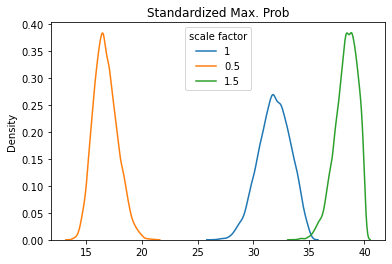

In [10]:
labels = ['1','0.5','1.5']
for i, probs in enumerate([probs_1, probs_2, probs_3]):
    true_stddevs = probs.std(axis=1)
    true_means = probs.mean(axis=1)
    true_maxs = probs.max(axis=1)
    true_std_maxs = (true_maxs - true_means) / true_stddevs
    ax = sns.kdeplot(true_std_maxs, label=labels[i])
ax.legend(title='scale factor')
ax.set_title("Standardized Max. Prob")

In [13]:
scale_param = 1
probs_true = lmnl.get_probs(choosers, alts, coeffs, key, scale=scale_param)

true_stddevs = probs_true.std(axis=1)
true_means = probs_true.mean(axis=1)
true_maxs = probs_true.max(axis=1)
true_std_maxs = (true_maxs - true_means) / true_stddevs
true_massing = probs_true.sum(axis=0)
order = probs_true.sum(axis=0).argsort()[::-1]

# fig, axarr = plt.subplots(5, 1, figsize=(15,20))
    
for sample_rate in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    
    sample_size = int(num_alts * sample_rate)
    samp_alt_idxs, probs_samp = lmnl.get_probs(choosers, alts, coeffs, key, sample_size, scale=scale_param)
    
    samp_stddevs = probs_samp.std(axis=1)
    samp_means = probs_samp.mean(axis=1)
    samp_maxs = probs_samp.max(axis=1)
    samp_std_maxs = (samp_maxs - samp_means) / samp_stddevs
#     sns.kdeplot(samp_std_maxs, label=sample_rate, ax=axarr[0], alpha=0.4)
    
    probs_samp_sparse = np.zeros_like(probs_true)
    probs_samp_sparse[
        np.array(range(num_choosers)).repeat(sample_size), samp_alt_idxs.flatten()] = probs_samp.flatten()

    sampled_massing = probs_samp_sparse.sum(axis=0)
    break
#     sns.regplot(
#         x=true_massing, y=sampled_massing, label=sample_rate,
#         order=2, 
#         ax=axarr[1],
#         line_kws={'lw':1}, scatter_kws={'marker':'.', 'alpha':0.5, 's':1}
#     )
    
#     axarr[2].plot(np.arange(num_alts), sampled_massing[order], alpha=0.5, label=sample_rate, lw=.7)
    
#     massing_err = (sampled_massing - true_massing)
#     axarr[3].scatter(true_massing[order], massing_err[order],
#                label=str(sample_rate), marker='.',  alpha=0.5)
#     z = sm.nonparametric.lowess(massing_err[order], true_massing[order], frac=.1, it=5)
#     axarr[3].plot(z[:,0], z[:,1],lw=1, alpha=0.5)
    
#     total_massing_err = np.abs(massing_err).sum()
#     axarr[4].scatter(sample_rate, total_massing_err, label=sample_rate)

# sns.kdeplot(true_std_maxs, label='True', ax=axarr[0], c='k')
# axarr[0].legend(title='Sample Rate')
# axarr[0].set_title("Standardized Max. Prob")
# axarr[0].set_xlabel("$(p_{max} - p_{mean}) / p_{std}$")
    
# axarr[1].legend(title='Sample Rate')
# axarr[1].set_title('probability massing')
# axarr[1].set_ylabel('sampled')
# axarr[1].set_xlabel('no sampling ("True")')
# lims = [
#     min(min(axarr[1].get_xlim()), min(axarr[1].get_ylim())),  # min of both axes
#     max(max(axarr[1].get_xlim()), max(axarr[1].get_ylim())),  # max of both axes
# ]
# axarr[1].plot(lims, lims, 'k--', lw=0.5, zorder=0)

# axarr[2].plot(np.arange(num_alts), true_massing[order], color='k', alpha=.5, lw=1, label='True', zorder=0)
# axarr[2].legend(title='sample size')
# axarr[2].set_title('probability massing')
# axarr[2].set_ylabel('$\Sigma p$')
# axarr[2].set_xlabel('Alternative ID')

# axarr[3].set_title('Probability Massing Error')
# axarr[3].set_xlabel('True Probability Mass')
# axarr[3].set_ylabel('Error')
# # axarr[3].set_yscale('symlog')
# axarr[3].legend(title='Sample Rate')
# axarr[3].axhline(y=0, color='k', linestyle='--', lw=0.5, zorder=0)

# axarr[4].set_title("Total Abs. Probability Massing Error")
# axarr[4].legend(title='Sample Rate')
# axarr[4].set_ylabel("")

# fig.tight_layout()

In [50]:
scale_params = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
iters = 10

In [59]:
de_df = pd.DataFrame()

In [63]:
# fig, axarr = plt.subplots(2, 3 ,figsize=(15,10))
for i in range(iters):
    choosers, alts = cim.create_data(num_alts, num_choosers)
    print(i)
    for scale_param in scale_params:
        
        scale_df = pd.DataFrame()

        total_massing_errs = []
        rmses = []
        mapes = []
        probs_true = lmnl.get_probs(choosers, alts, coeffs, key, scale=scale_param)

        true_stddevs = probs_true.std(axis=1)
        true_means = probs_true.mean(axis=1)
        true_maxs = probs_true.max(axis=1)
        true_std_maxs = (true_maxs - true_means) / true_stddevs
        true_massing = probs_true.sum(axis=0)
        order = probs_true.sum(axis=0).argsort()[::-1]

        for sample_rate in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:

            sample_size = int(num_alts * sample_rate)
            samp_alt_idxs, probs_samp = lmnl.get_probs(choosers, alts, coeffs, key, sample_size, scale=scale_param)

            probs_samp_sparse = np.zeros_like(probs_true)
            probs_samp_sparse[
                np.array(range(num_choosers)).repeat(sample_size), samp_alt_idxs.flatten()] = probs_samp.flatten()

            sampled_massing = probs_samp_sparse.sum(axis=0)
            massing_err = (sampled_massing - true_massing)
            total_massing_err = np.abs(massing_err).sum()
            rmse = np.sqrt(np.mean(massing_err * massing_err))
            mape = np.mean(np.abs(massing_err / true_massing))
            
            tmp_series = pd.Series({
                'iter': i, 'scale': scale_param, 'sample_rate': sample_rate,
                'total': total_massing_err, 'rmse': rmse, 'mape': mape})
            scale_df = scale_df.append(tmp_series, ignore_index=True)

            rmses.append(rmse)
            total_massing_errs.append(total_massing_err)
            mapes.append(mape)
            
        total_massing_errs_normed = total_massing_errs / max(total_massing_errs)
        rmses_normed = rmses / max(rmses)
        mapes_normed = mapes / max(mapes)
        
        scale_df['total_normed'] = scale_df['total'] / scale_df['total'].max()
        scale_df['rmse_normed'] = scale_df['rmse'] / scale_df['rmse'].max()
        scale_df['mape_normed'] = scale_df['mape'] / scale_df['mape'].max()
        
        de_df = pd.concat((de_df, scale_df), ignore_index=True)
    
#     axarr[0, 0].plot(sample_rates, total_massing_errs, label=scale_param, alpha=0.6)
#     axarr[0, 1].plot(sample_rates, rmses, label=scale_param, alpha=0.6)
#     axarr[0, 2].plot(sample_rates, mapes, label=scale_param, alpha=0.6)
    
#     axarr[1, 0].plot(sample_rates, total_massing_errs / max(total_massing_errs), label=scale_param, alpha=0.6)
#     axarr[1, 1].plot(sample_rates, rmses / max(rmses), label=scale_param, alpha=0.6)
#     axarr[1, 2].plot(sample_rates, mapes / max(mapes), label=scale_param, alpha=0.6)

# axarr[0, 0].legend(title='Scale Param.')
# axarr[0, 0].set_title("Total Absolute Error")
# axarr[0, 0].set_xlabel("Sample Rate")
# axarr[0, 0].set_ylabel("")

# axarr[0, 1].legend(title='Scale Param.')
# axarr[0, 1].set_title("RMSE")
# axarr[0, 1].set_xlabel("Sample Rate")
# axarr[0, 1].set_ylabel("")

# axarr[0, 2].legend(title='Scale Param.')
# axarr[0, 2].set_title("MAPE")
# axarr[0, 2].set_xlabel("Sample Rate")
# axarr[0, 2].set_ylabel("")

# axarr[1, 0].legend(title='Scale Param.')
# axarr[1, 0].set_title("Total Absolute Error")
# axarr[1, 0].set_xlabel("Sample Rate")
# axarr[1, 0].set_ylabel("")

# axarr[1, 1].legend(title='Scale Param.')
# axarr[1, 1].set_title("RMSE")
# axarr[1, 1].set_xlabel("Sample Rate")
# axarr[1, 1].set_ylabel("")

# axarr[1, 2].legend(title='Scale Param.')
# axarr[1, 2].set_title("MAPE")
# axarr[1, 2].set_xlabel("Sample Rate")
# axarr[1, 2].set_ylabel("")

# fig.suptitle("Dispersion Error", fontsize=20)

0
1


/tmp/ipykernel_3823598/3936237851.py:47: RuntimeWarning: invalid value encountered in true_divide
  mapes_normed = mapes / max(mapes)


2
3
4
5
6
7
8
9


/home/mgardner/anaconda3/envs/proba/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(0.5, 0.98, 'Dispersion Error')

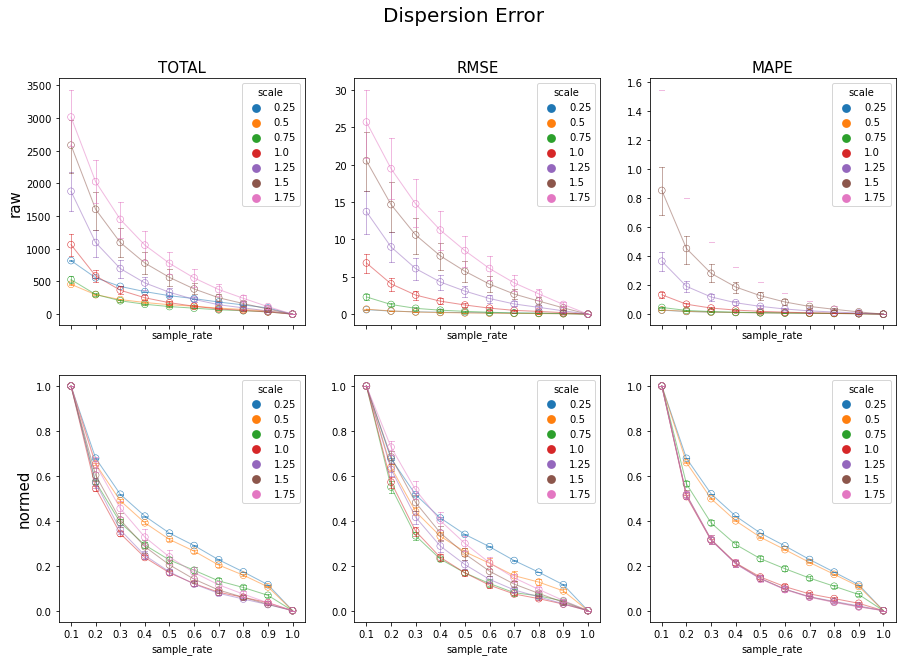

In [73]:
fig, axarr = plt.subplots(2, 3 ,figsize=(15,10), sharex=True)
for i, col in enumerate(['total', 'rmse', 'mape']):
    g = sns.pointplot(
        x=de_df['sample_rate'], y=de_df[col], ax=axarr[0, i], hue=de_df['scale'], capsize=.2)
    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines
    axarr[0, i].set_ylabel("")
    axarr[0, i].set_title(col.upper(), fontsize=15)
    
    g = sns.pointplot(
        x=de_df['sample_rate'], y=de_df[col + '_normed'], ax=axarr[1, i], hue=de_df['scale'].astype(str), capsize=.2)
    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines
    axarr[1, i].set_ylabel("")
    
axarr[0, 0].set_ylabel("raw", fontsize=15)
axarr[1, 0].set_ylabel("normed", fontsize=15)
    
fig.suptitle("Dispersion Error", fontsize=20)

Text(0.5, 0.98, 'Probability Massing Stats')

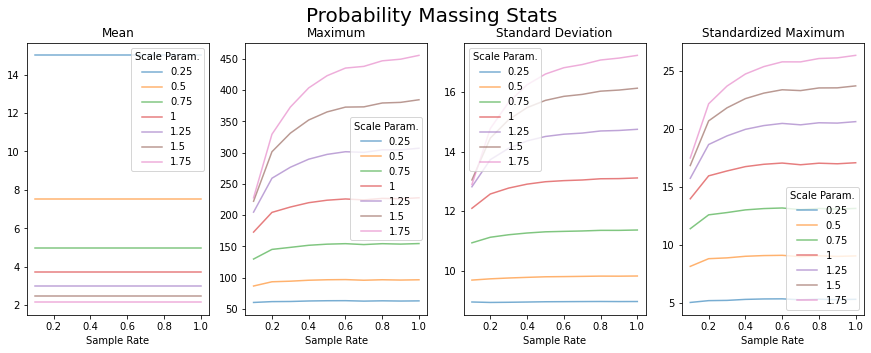

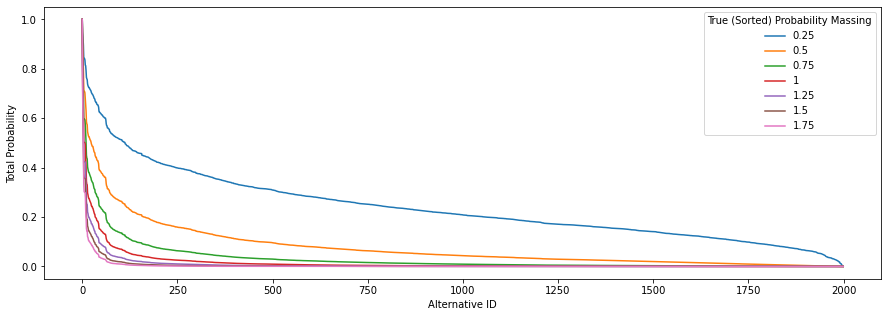

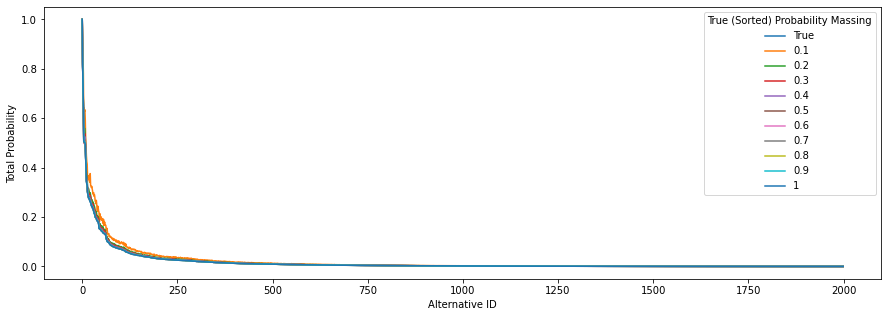

In [24]:
fig1, axarr = plt.subplots(1, 4 ,figsize=(15,5))
fig2, ax = plt.subplots(figsize=(15,5))
fig3, ax2 = plt.subplots(figsize=(15,5))
for scale_param in scale_params:
    
    means = np.array([])
    maxs = np.array([])
    stds = np.array([])
    probs_true = lmnl.get_probs(choosers, alts, coeffs, key, scale=scale_param)

    true_massing = probs_true.sum(axis=0)
    true_massing_mean = true_massing.mean()
    true_massing_max = true_massing.max()
    true_massing_stddev = true_massing.std()
    order = true_massing.argsort()[::-1]
    
    ax.plot(np.arange(num_alts), true_massing[order] / true_massing[order].max(), label=scale_param)
    
    if scale_param == 1:
        ax2.plot(np.arange(num_alts), true_massing[order] / true_massing[order].max(), label='True')
    for sample_rate in sample_rates:
    
        sample_size = int(num_alts * sample_rate)
        samp_alt_idxs, probs_samp = lmnl.get_probs(choosers, alts, coeffs, key, sample_size, scale=scale_param)

        probs_samp_sparse = np.zeros_like(probs_true)
        probs_samp_sparse[
            np.array(range(num_choosers)).repeat(sample_size), samp_alt_idxs.flatten()] = probs_samp.flatten()
        
        sampled_massing = probs_samp_sparse.sum(axis=0)
        if scale_param == 1:
            ax2.plot(np.arange(num_alts), sampled_massing[order] / sampled_massing[order].max(), label=sample_rate)
        
        sampled_massing_mean = sampled_massing.mean()
        sampled_massing_max = sampled_massing.max()
        sampled_massing_stddev = sampled_massing.std()
        
        means = np.append(means, sampled_massing_mean)
        maxs = np.append(maxs, sampled_massing_max)
        stds = np.append(stds, sampled_massing_stddev)
    
    axarr[0].plot(sample_rates, means, label=scale_param, alpha=0.6)
    axarr[1].plot(sample_rates, maxs, label=scale_param, alpha=0.6)
    axarr[2].plot(sample_rates, stds, label=scale_param, alpha=0.6)
    axarr[3].plot(sample_rates, (maxs - means) / stds, label=scale_param, alpha=0.6)
    
ax.legend(title='True (Sorted) Probability Massing')
ax.set_xlabel("Alternative ID")
ax.set_ylabel("Total Probability")

ax2.legend(title='True (Sorted) Probability Massing')
ax2.set_xlabel("Alternative ID")
ax2.set_ylabel("Total Probability")

axarr[0].legend(title='Scale Param.')
axarr[0].set_title("Mean")
axarr[0].set_xlabel("Sample Rate")
axarr[0].set_ylabel("")

axarr[1].legend(title='Scale Param.')
axarr[1].set_title("Maximum")
axarr[1].set_xlabel("Sample Rate")
axarr[1].set_ylabel("")

axarr[2].legend(title='Scale Param.')
axarr[2].set_title("Standard Deviation")
axarr[2].set_xlabel("Sample Rate")
axarr[2].set_ylabel("")

axarr[3].legend(title='Scale Param.')
axarr[3].set_title("Standardized Maximum")
axarr[3].set_xlabel("Sample Rate")
axarr[3].set_ylabel("")

fig1.suptitle("Probability Massing Stats", fontsize=20)

In [34]:
1/(2000*.25)*7500

15.0

## Probability Massing (Alt. Shares)

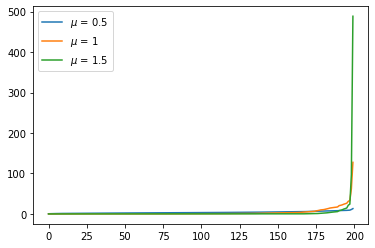

In [29]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_alts), probs_2.sort(axis=1).sum(axis=0), label='$\mu$ = 0.5')
ax.plot(np.arange(num_alts), probs_1.sort(axis=1).sum(axis=0), label='$\mu$ = 1')
ax.plot(np.arange(num_alts), probs_3.sort(axis=1).sum(axis=0), label='$\mu$ = 1.5')
ax.legend()

## Probability Massing Error

Text(0, 0.5, 'abs err')

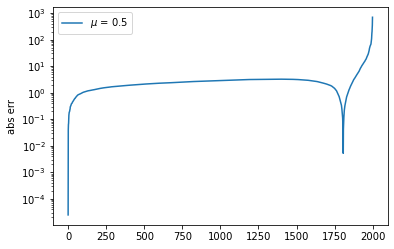

In [40]:
fig, ax = plt.subplots()
pm_1 = probs_1.sort(axis=1).sum(axis=0)
pm_2 = probs_2.sort(axis=1).sum(axis=0)
pm_3 = probs_3.sort(axis=1).sum(axis=0)
ax.plot(np.arange(num_alts), np.abs(pm_2 - pm_1), label='$\mu$ = 0.5')
ax.legend()
ax.set_yscale('log')
ax.set_ylabel("abs err")

Text(0, 0.5, 'abs % err')

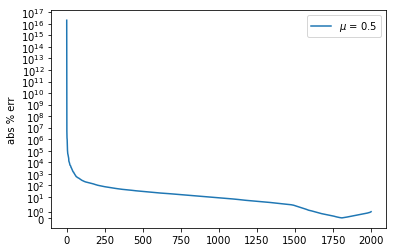

In [41]:
fig, ax = plt.subplots()
pm_1 = probs_1.sort(axis=1).sum(axis=0)
pm_2 = probs_2.sort(axis=1).sum(axis=0)
pm_3 = probs_3.sort(axis=1).sum(axis=0)
ax.plot(np.arange(num_alts), np.abs(pm_2 - pm_1) / pm_1, label='$\mu$ = 0.5')
ax.legend()
ax.set_yscale('symlog')
ax.set_ylabel("abs % err")

Text(0, 0.5, 'sq err')

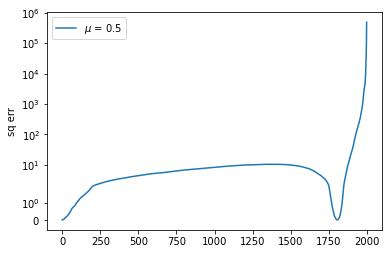

In [42]:
fig, ax = plt.subplots()
pm_1 = probs_1.sort(axis=1).sum(axis=0)
pm_2 = probs_2.sort(axis=1).sum(axis=0)
pm_3 = probs_3.sort(axis=1).sum(axis=0)
ax.plot(np.arange(num_alts), (pm_2 - pm_1) * (pm_2 - pm_1), label='$\mu$ = 0.5')
ax.legend()
ax.set_yscale('symlog')
ax.set_ylabel("sq err")